In [1]:
from Utility05_Bayesian import *
# from bayes_opt import BayesianOptimization
from tiramisu_net import *
import scipy.io
import cv2
import multiprocessing
from OsUtils import *
import tensorflow as tf

In [2]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 1794262286407037839
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 10319101952
locality {
  bus_id: 1
  links {
  }
}
incarnation: 9496473614709960651
physical_device_desc: "device: 0, name: NVIDIA TITAN V, pci bus id: 0000:65:00.0, compute capability: 7.0"
]


In [3]:
from meta_info import *
N_MCS=20

## Structure data

In [4]:
MFW_data=np.load(cd_str+'ZL_dataset/'+str(new_H)+'x'+str(new_W)+'_'+data_type+'_MFW_data.npz')

pixel_unique=MFW_data['pixel_unique']
pixel_count=MFW_data['pixel_count']
class_weights_freq=MFW_data['class_weights_freq']

print('pixel_unique:')
print(pixel_unique)

print('pixel_count:')
pixel_count[1]=sum(pixel_count[1:])
pixel_count=pixel_count[0:5]
print(pixel_count)
pixel_med=np.median(pixel_count)
class_weights_freq=pixel_med/pixel_count

print('class_weights_freq:')
print(class_weights_freq)

Big_data_dictionary=load_pickle(cd_str+'ZL_dataset/Big_data_dictionary')

pixel_unique:
[0. 1.]
pixel_count:
[21884534   752266]
class_weights_freq:
[ 0.51718716 15.0457418 ]


In [5]:
# this class only helps visualize the data and is not a generator
class ZL_data_split:
    
    def __init__(self,
                 data_split_dict,split_type,split_id,
                 new_H=new_H,new_W=new_W):
        
        self.data_split_dict=data_split_dict
        self.split_id=split_id      # 'train', 'val', 'test'
        self.split_type=split_type  # 'tool', 'agent', 'setup', 'random'
        self.new_H = new_H
        self.new_W = new_W        
        
        self.split_key=self.split_id+'_indx_bin'
        self.vid_frm_id_bin=self.data_split_dict[self.split_type][self.split_key]
        self.n_obs = len(self.vid_frm_id_bin)
    
    def load_data(self,image_id, resize=True,verbose=0,
                  norm_RGB=255):
        
        split_key=self.split_id+'_indx_bin'
        vid_frm_id_bin=self.data_split_dict[self.split_type][split_key][image_id]
        
        data_tmp=np.load(cd_str+'ZL_dataset/proc_'+str(self.new_H)+'x'+str(self.new_W)\
                                                    +'/'+vid_frm_id_bin+'.npz')
        img_i=data_tmp['X']/norm_RGB
        mask_i=data_tmp['Y']

#         if resize:
#             mask_i = cv2.resize(np.array(mask_i), (self.new_W,self.new_H), interpolation =cv2.INTER_NEAREST)
#             img_i = cv2.resize(np.array(img_i), (self.new_W,self.new_H), interpolation =cv2.INTER_NEAREST)
            
        if verbose==1:
            print('img_i.shape:  '+str(img_i.shape))
            print('mask_i.shape: '+str(mask_i.shape))
            
        return mask_i,img_i    

In [6]:
training_set=ZL_data_split(Big_data_dictionary,data_type,'train',new_W=new_W,new_H=new_H)
val_set=ZL_data_split(Big_data_dictionary,data_type,'val',new_W=new_W,new_H=new_H)
test_set=ZL_data_split(Big_data_dictionary,data_type,'test',new_W=new_W,new_H=new_H)

In [7]:
class DataGenerator(tf.keras.utils.Sequence):
    'Generates data for Keras'
    def __init__(self, class_weights, batch_size,
                 data_split_dict,split_type,split_id,train_sp,
                 n_classes=2, shuffle=True, new_H=new_H, new_W=new_W):
        'Initialization'
        self.data_split_dict=data_split_dict
        self.split_type=split_type
        self.split_id=split_id
        self.train_sp=train_sp
        self.batch_size = batch_size
        self.class_weights = class_weights
        
        self.n_classes = n_classes
        self.shuffle = shuffle
        self.split_key=self.split_id+'_indx_bin'
        self.vid_frm_id_bin=self.data_split_dict[self.split_type][self.split_key]
        
        
        self.new_H = new_H
        self.new_W = new_W
        
        self.n_obs = len(self.vid_frm_id_bin)
        self.n_first=0
        self.n_last=self.n_obs
        
        if self.split_id=='train':
            if train_sp=='sp1':
                self.n_first=0
                self.n_last=int(len(self.vid_frm_id_bin)/2)
                self.n_obs=len(self.vid_frm_id_bin[self.n_first:self.n_last])                
            elif train_sp=='sp2':
                self.n_first=int(len(self.vid_frm_id_bin)/2)
                self.n_last=len(self.vid_frm_id_bin)
                self.n_obs=len(self.vid_frm_id_bin[self.n_first:self.n_last]) 
            elif train_sp=='all':
                pass
            else:
                print('invalid sp')
            
        self.on_epoch_end()

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.ceil(self.n_obs / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        # Generate data
        data_tuple = self.__data_generation(indexes)

        return data_tuple

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(self.n_first,self.n_last,1) # only train on the first half of training set
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def __data_generation(self, indexes):
        'Generates data containing batch_size samples' # X : (n_samples, *dim, n_channels)
        # Initialization
        batch_size_auto=indexes.shape[0]
        X = np.empty((batch_size_auto, self.new_H,self.new_W, 3))
        y = np.empty((batch_size_auto, self.new_H,self.new_W), dtype=int)

        # Generate data
        for i, ID in enumerate(indexes):
            # Store sample
            vid_frm_id=self.vid_frm_id_bin[ID]
            data_tmp=np.load(cd_str+'ZL_dataset/proc_'+str(self.new_H)+'x'+str(self.new_W)\
                                                        +'/'+vid_frm_id+'.npz')
            norm_RGB=255
            X[i,]=data_tmp['X']/norm_RGB
            y[i]=data_tmp['Y']            
            
#             img_i = scipy.io.loadmat(self.set_dir+'/img_'+str(ID+1)+'.mat')['img']/255
#             X[i,] = cv2.resize(np.array(img_i), (self.new_W,self.new_H), interpolation =cv2.INTER_NEAREST)
            
            # Store class
#             mask_i = scipy.io.loadmat(self.set_dir+'/hand_mask_'+str(ID+1)+'.mat')['hand_mask']
#             y[i] = cv2.resize(np.array(mask_i), (self.new_W,self.new_H), interpolation =cv2.INTER_NEAREST)-1
            
        # [y>1]=1
        y_resh=y.reshape((-1,self.new_H*self.new_W))
#         print(np.amax(y_resh))
#         print(y_resh.shape)
        y_cat=tf.keras.utils.to_categorical(y_resh, num_classes=self.n_classes)
        batch_wieghts = gen_weight_mat(y,self.class_weights)
        
        return (X, y_cat,batch_wieghts)

## Inference

In [8]:
import tensorflow as tf

In [9]:
# graph1 = tf.Graph()
# with graph1.as_default():
#     session1 = tf.Session()
#     with session1.as_default():
#         main_model=load_model('test.h5')
# print('main model loaded')    

# graph2 = tf.Graph()
# with graph2.as_default():
#     session2 = tf.Session()
#     with session2.as_default():
#         SRG_model=load_model('test_SRG.h5')
        
# print('SRG model loaded') 

In [10]:
class Model:
    @staticmethod
    def loadmodel(path):
        return load_model(path)

    def __init__(self, path):
        
        self.graph = tf.compat.v1.get_default_graph()
        
        with self.graph.as_default():
            self.model = self.loadmodel(path)

    def predict(self, X):
        with self.graph.as_default():
            return self.model.predict(X)

In [11]:
main_model=Model('test.h5')
main_model_all=Model('test_all.h5')
SRG_model=Model('SRG_MW.h5')

Instructions for updating:
Colocations handled automatically by placer.


In [12]:
def Monty_Model_softmax_X(X,model, N_MCS):
    SoftMaxBin_list=[]
    for i in range(N_MCS):
        SoftMaxBin_list.append(model.predict(X))
    SoftMaxBin=np.array(SoftMaxBin_list)
    
    SoftmaxMean=np.mean(SoftMaxBin,axis=0)
    SoftmaxStd=np.std(SoftMaxBin,axis=0)

    return SoftmaxMean,SoftmaxStd

### Visualization

In [13]:
import time

N_MCS_main=20
N_MCS_SRG=1

Obs. 1 processed, t_load: 0.004, t_MCS: 0.369, t_ENTP: 0.003, t_inSRG: 0.002, t_SRG: 0.018 t_sum= 0.396 (s)


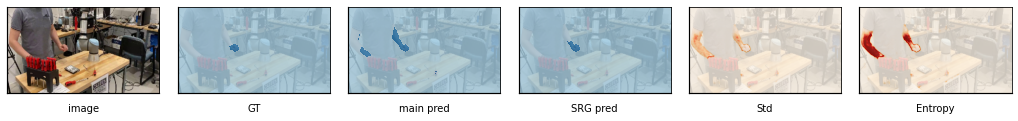

Obs. 6 processed, t_load: 0.009, t_MCS: 0.409, t_ENTP: 0.008, t_inSRG: 0.003, t_SRG: 0.021 t_sum= 0.450 (s)


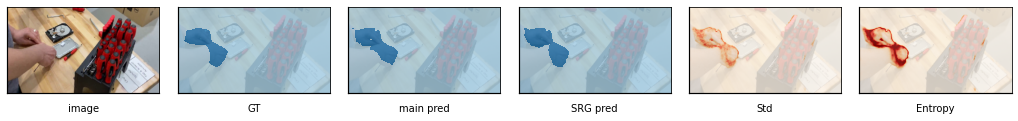

Obs. 11 processed, t_load: 0.004, t_MCS: 0.388, t_ENTP: 0.002, t_inSRG: 0.002, t_SRG: 0.018 t_sum= 0.414 (s)


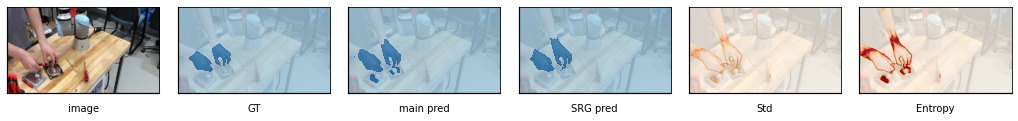

Obs. 16 processed, t_load: 0.012, t_MCS: 0.407, t_ENTP: 0.003, t_inSRG: 0.001, t_SRG: 0.021 t_sum= 0.444 (s)


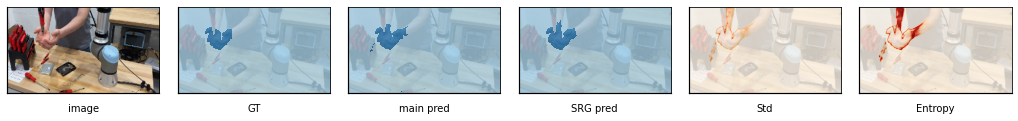

Obs. 21 processed, t_load: 0.003, t_MCS: 0.386, t_ENTP: 0.002, t_inSRG: 0.002, t_SRG: 0.022 t_sum= 0.415 (s)


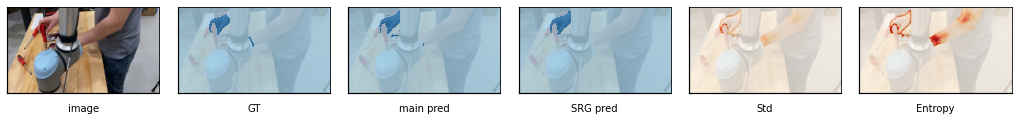

Obs. 26 processed, t_load: 0.004, t_MCS: 0.403, t_ENTP: 0.003, t_inSRG: 0.002, t_SRG: 0.016 t_sum= 0.428 (s)


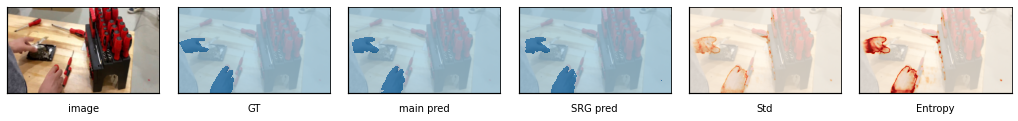

Obs. 31 processed, t_load: 0.004, t_MCS: 0.385, t_ENTP: 0.003, t_inSRG: 0.002, t_SRG: 0.019 t_sum= 0.413 (s)


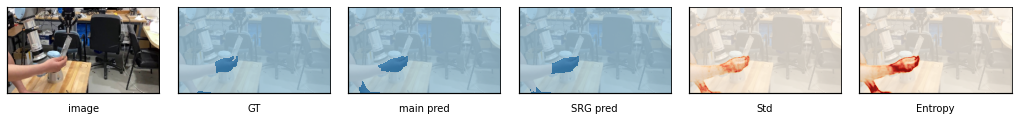

Obs. 36 processed, t_load: 0.011, t_MCS: 0.401, t_ENTP: 0.003, t_inSRG: 0.001, t_SRG: 0.019 t_sum= 0.435 (s)


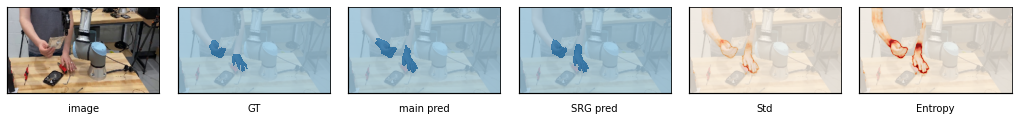

Obs. 41 processed, t_load: 0.004, t_MCS: 0.413, t_ENTP: 0.004, t_inSRG: 0.004, t_SRG: 0.018 t_sum= 0.443 (s)


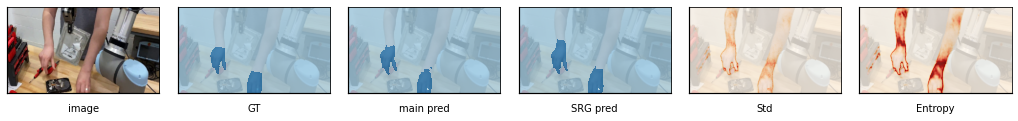

Obs. 46 processed, t_load: 0.003, t_MCS: 0.391, t_ENTP: 0.002, t_inSRG: 0.002, t_SRG: 0.019 t_sum= 0.417 (s)


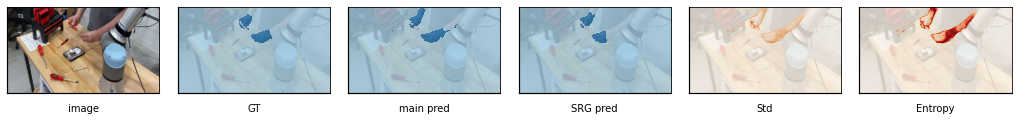

Obs. 51 processed, t_load: 0.011, t_MCS: 0.413, t_ENTP: 0.003, t_inSRG: 0.001, t_SRG: 0.017 t_sum= 0.445 (s)


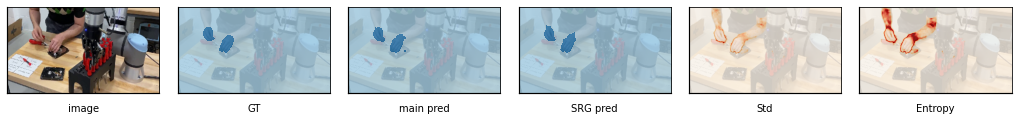

Obs. 56 processed, t_load: 0.007, t_MCS: 0.403, t_ENTP: 0.003, t_inSRG: 0.001, t_SRG: 0.017 t_sum= 0.431 (s)


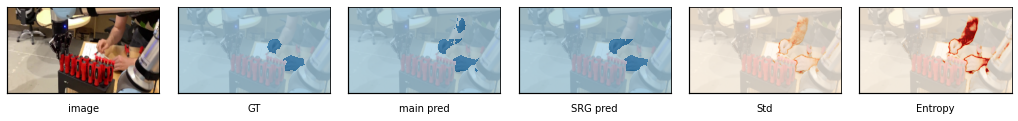

Obs. 61 processed, t_load: 0.004, t_MCS: 0.381, t_ENTP: 0.002, t_inSRG: 0.002, t_SRG: 0.018 t_sum= 0.407 (s)


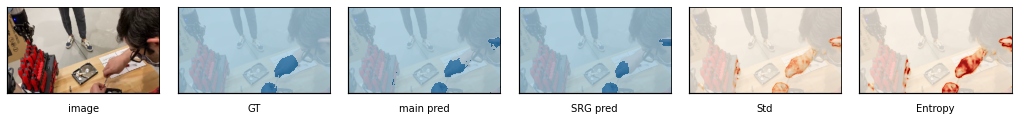

Obs. 66 processed, t_load: 0.003, t_MCS: 0.412, t_ENTP: 0.004, t_inSRG: 0.002, t_SRG: 0.019 t_sum= 0.440 (s)


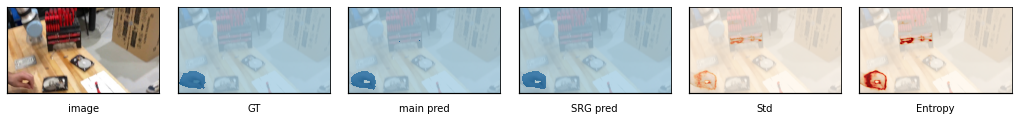

Obs. 71 processed, t_load: 0.004, t_MCS: 0.411, t_ENTP: 0.002, t_inSRG: 0.002, t_SRG: 0.020 t_sum= 0.439 (s)


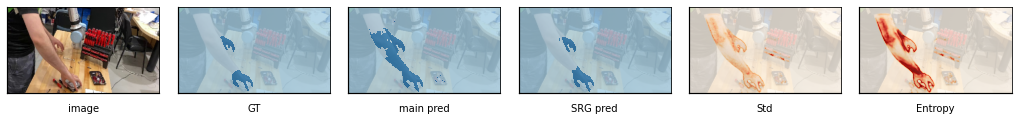

Obs. 76 processed, t_load: 0.009, t_MCS: 0.393, t_ENTP: 0.003, t_inSRG: 0.001, t_SRG: 0.015 t_sum= 0.421 (s)


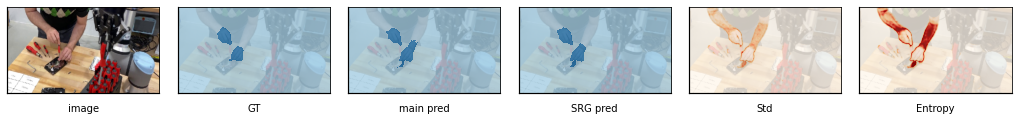

Obs. 81 processed, t_load: 0.011, t_MCS: 0.391, t_ENTP: 0.003, t_inSRG: 0.002, t_SRG: 0.020 t_sum= 0.427 (s)


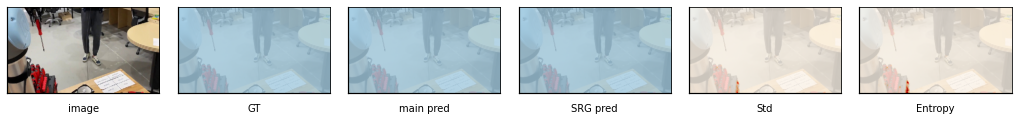

Obs. 86 processed, t_load: 0.004, t_MCS: 0.387, t_ENTP: 0.003, t_inSRG: 0.001, t_SRG: 0.019 t_sum= 0.414 (s)


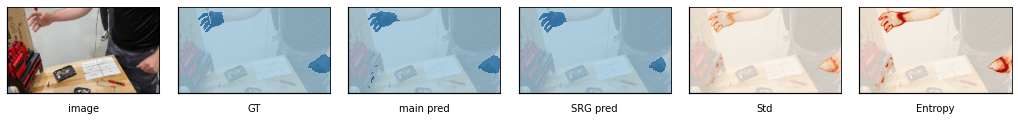

Obs. 91 processed, t_load: 0.011, t_MCS: 0.379, t_ENTP: 0.002, t_inSRG: 0.002, t_SRG: 0.016 t_sum= 0.410 (s)


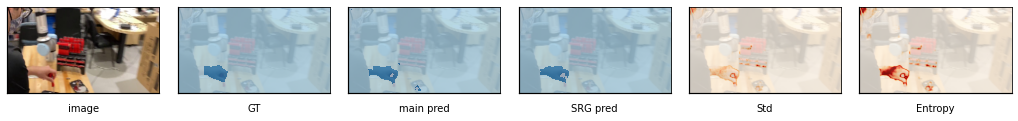

Obs. 96 processed, t_load: 0.004, t_MCS: 0.391, t_ENTP: 0.003, t_inSRG: 0.002, t_SRG: 0.020 t_sum= 0.420 (s)


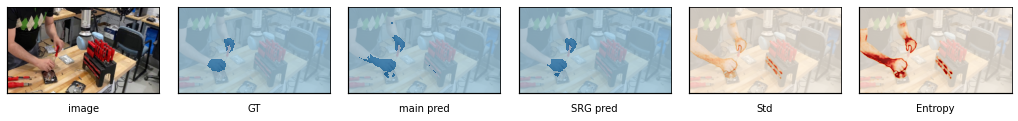

Obs. 101 processed, t_load: 0.010, t_MCS: 0.409, t_ENTP: 0.003, t_inSRG: 0.001, t_SRG: 0.023 t_sum= 0.446 (s)


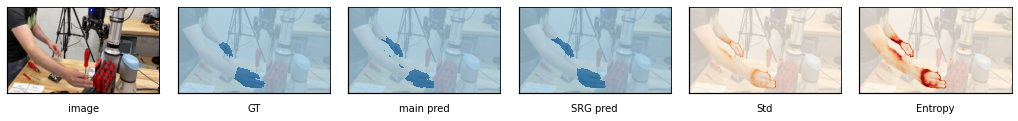

Obs. 106 processed, t_load: 0.005, t_MCS: 0.405, t_ENTP: 0.003, t_inSRG: 0.001, t_SRG: 0.019 t_sum= 0.433 (s)


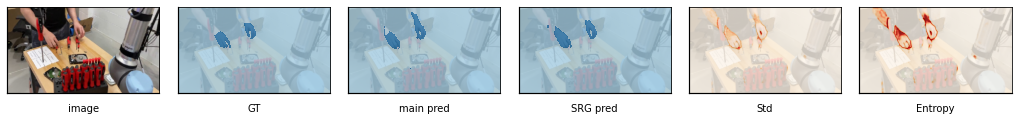

Obs. 111 processed, t_load: 0.010, t_MCS: 0.428, t_ENTP: 0.002, t_inSRG: 0.002, t_SRG: 0.018 t_sum= 0.460 (s)


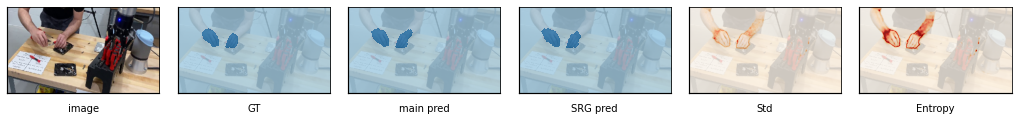

In [18]:
data_set=test_set

t_bin=[]

alpha=0.8


for i_obs in np.arange(0,test_set.n_obs,5):
    
    t0 = time.time() ## initiate data loading 
    mask_i,img_i = data_set.load_data(i_obs,verbose=0,resize=True)
    img_i=img_i.reshape((1,)+img_i.shape)
    mask_i=mask_i.reshape((1,)+mask_i.shape)

#     mask_i[mask_i>2]=2
    
    t1 = time.time() ## initiate MCS
    SoftmaxMean_main_i,SoftmaxStd_main_i=Monty_Model_softmax_X(img_i,main_model, N_MCS_main)
    
    t2 = time.time() ## entropy calcs

    p_c=SoftmaxMean_main_i
    max_p=np.sum(SoftmaxMean_main_i,axis=-1)
    max_p=np.reshape(max_p,max_p.shape+(1,))
    p_c_norm=np.divide(p_c,max_p)
    log_p_c=np.log10(p_c_norm+1e-12)
    entropy_i=np.sum(np.multiply(-1*p_c_norm,log_p_c),axis=-1)

    t3 = time.time() ## save to file
    SoftmaxStd_main_i=SoftmaxStd_main_i.reshape(1,data_set.new_H,data_set.new_W,2)
    SoftmaxMean_main_i=SoftmaxMean_main_i.reshape(1,data_set.new_H,data_set.new_W,2)
    entropy_i=entropy_i.reshape((1,data_set.new_H,data_set.new_W,1))
    X_SRG=np.concatenate((img_i,SoftmaxMean_main_i,SoftmaxStd_main_i,entropy_i),axis=-1) 

    
    
    # np.savez_compressed(set_dir+'/X_SRG_'+str(i_obs+1)+'.npz',X_SRG=X_SRG)

    t4 = time.time() ## Initiate second inference
    
    SoftmaxMean_SRG_i,SoftmaxStd_SRG_i=Monty_Model_softmax_X(X_SRG,SRG_model, N_MCS_SRG)
    
    y_pred_SRG=np.argmax(SoftmaxMean_SRG_i,axis=-1).reshape(1,data_set.new_H,data_set.new_W)
    
    t5 = time.time() ## End of inference 
    
    # times
    dt_1=t1-t0  # load data
    dt_2=t2-t1  # perform MCS
    dt_3=t3-t2  # measure entropy
    dt_4=t4-t3  # Build SRG input
    dt_5=t5-t4  # SRG inference
    t_sum=t5-t0
    
    # benchmark with the model trained on all observations
    SoftmaxMean_main_all_i,SoftmaxStd_main_all_i=Monty_Model_softmax_X(img_i,main_model_all, N_MCS_main)
    y_pred_main=np.argmax(SoftmaxMean_main_all_i,axis=-1).reshape((1,data_set.new_H,data_set.new_W))
    
    
    t_bin.append([dt_1,dt_2,dt_3,dt_4,dt_5])
    print('Obs. %d processed, t_load: %1.3f, t_MCS: %1.3f, t_ENTP: %1.3f, t_inSRG: %1.3f, t_SRG: %1.3f t_sum= %1.3f (s)'%((i_obs+1,dt_1,dt_2,dt_3,dt_4,dt_5,t_sum)))
    
    fig,ax = plt.subplots(1,6,figsize=(18,3))
    plt.subplots_adjust(wspace=0.12, hspace=0.1)
    
    for i in range(6):
        ax[i].spines['top'].set_visible(1.2)
        ax[i].spines['right'].set_visible(1.2)
        ax[i].spines['bottom'].set_linewidth(1.2)
        ax[i].spines['left'].set_linewidth(1.2)
        ax[i].set_yticklabels([])
        ax[i].set_xticklabels([])
        ax[i].tick_params(bottom=False, left=False)
    
    ax[0].imshow(img_i[0])
    ax[0].set_xlabel('image')

    ax[1].imshow(img_i[0])
    ax[1].imshow(mask_i[0],alpha=alpha,cmap='Paired',vmin=0,vmax=8,interpolation='nearest')
    ax[1].set_xlabel('GT')
    
    ax[2].imshow(img_i[0])
    ax[2].imshow(y_pred_main[0],alpha=alpha,cmap='Paired',vmin=0,vmax=8,interpolation='nearest')
    ax[2].set_xlabel('main pred')

    ax[3].imshow(img_i[0])
    ax[3].imshow(y_pred_SRG[0],alpha=alpha,cmap='Paired',vmin=0,vmax=8,interpolation='nearest')
    ax[3].set_xlabel('SRG pred')
    
    ax[4].imshow(img_i[0])
    ax[4].imshow(SoftmaxStd_main_i[0,:,:,1],alpha=alpha,cmap='OrRd')
    ax[4].set_xlabel('Std')    
    
    ax[5].imshow(img_i[0])
    ax[5].imshow(entropy_i[0,:,:,0],alpha=alpha,cmap='OrRd')
    ax[5].set_xlabel('Entropy')    
    
    
    plot_save_name='test_save/'+str(i_obs+1).zfill(3)+'.png'
    fig.savefig(plot_save_name,dpi=150, pad_inches=0.1,bbox_inches='tight',facecolor='white')   
    
    plt.show()
    plt.close()

In [19]:
np.unique(mask_i)

array([0., 1.])

In [20]:
class DataGenerator_B(tf.keras.utils.Sequence):
    'Generates data for Keras'
    def __init__(self, class_weights, batch_size,
                 data_split_dict,split_type,split_id,train_sp,
                 n_classes=2, shuffle=True, new_H=new_H, new_W=new_W):
        'Initialization'
        self.batch_size = batch_size
        self.class_weights = class_weights
        self.n_classes = n_classes
        self.data_split_dict=data_split_dict
        self.split_type=split_type
        self.split_id=split_id
        self.train_sp=train_sp
        self.shuffle = shuffle
        self.new_H = new_H
        self.new_W = new_W      
        self.set_dir='SRG_'+self.split_id+'/'

        self.split_key=self.split_id+'_indx_bin'
        self.vid_frm_id_bin=self.data_split_dict[self.split_type][self.split_key]
        self.n_obs = len(self.vid_frm_id_bin)
        self.n_first=0
        self.n_last=self.n_obs
        
        if self.split_id=='train':
            if train_sp=='sp1':
                self.n_first=0
                self.n_last=int(len(self.vid_frm_id_bin)/2)
                self.n_obs=len(self.vid_frm_id_bin[self.n_first:self.n_last])                
            elif train_sp=='sp2':
                self.n_first=int(len(self.vid_frm_id_bin)/2)
                self.n_last=len(self.vid_frm_id_bin)
                self.n_obs=len(self.vid_frm_id_bin[self.n_first:self.n_last]) 
            elif train_sp=='all':
                pass
            else:
                print('invalid sp')       
        
        self.on_epoch_end()


    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.ceil(self.n_obs / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        # Generate data
        data_tuple = self.__data_generation(indexes)

        return data_tuple

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(self.n_first,self.n_last,1) # only train on the first half of training set
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def __data_generation(self, indexes):
        'Generates data containing batch_size samples' # X : (n_samples, *dim, n_channels)
        # Initialization
        batch_size_auto=indexes.shape[0]
        X = np.empty((batch_size_auto, self.new_H,self.new_W, 8))
        y = np.empty((batch_size_auto, self.new_H,self.new_W), dtype=int)

        # Generate data
        for i, ID in enumerate(indexes):
            # Store sample
            vid_frm_id=self.vid_frm_id_bin[ID]
            X[i,] = np.load(self.set_dir+'X_SRG_'+vid_frm_id+'.npz')['X_SRG'] # already normalized
            # Store class
            data_tmp=np.load(cd_str+'ZL_dataset/proc_'+str(self.new_H)+'x'+str(self.new_W)\
                                                        +'/'+vid_frm_id+'.npz')
            y[i]=data_tmp['Y']     
             
        #y[y>1]=1
        y_resh=y.reshape((-1,self.new_H*self.new_W))
#         print(np.amax(y_resh))
#         print(y_resh.shape)
        y_cat=tf.keras.utils.to_categorical(y_resh, num_classes=self.n_classes)
        batch_wieghts = gen_weight_mat(y,self.class_weights)
        
        return (X, y_cat,batch_wieghts)

In [21]:
batch_size_eval = 17
test_generator = test_generator = DataGenerator_B(
                               class_weights_freq,batch_size_eval,
                               Big_data_dictionary,data_type,'test','none',
                               new_W=new_W,new_H=new_H,
                               shuffle=False)

In [22]:
def Monty_Model_softmax_SRG(data_generator, model, N_MCS=N_MCS,steps=int(test_set.n_obs/batch_size_eval)):
    SoftMaxBin_list=[]
    for i in range(N_MCS):
        print(i)
        SoftMaxBin_list.append(model.predict(data_generator))  ## modify depending on tf version model.model.predict_generator(data_generator,steps=steps)
    SoftMaxBin=np.array(SoftMaxBin_list)
    SoftmaxMean=np.mean(SoftMaxBin,axis=0)
    SoftmaxStd=np.std(SoftMaxBin,axis=0)
    return SoftmaxMean,SoftmaxStd

In [23]:
SoftmaxMean_test_SRG,SoftmaxStd_test_SRG = Monty_Model_softmax_SRG(test_generator,SRG_model, N_MCS=N_MCS_SRG,steps=int(test_set.n_obs/batch_size_eval))

0


In [24]:
def Models_eval_hands_B(SoftmaxMean,y_get_set,save_fname):
    
    Y_pred=np.argmax(SoftmaxMean,axis=-1).reshape(-1,new_H,new_W)
    # precision, recall, f1
    prc_bin, rec_bin, f1_bin, _ =precision_recall_fscore_support(y_get_set.ravel(), Y_pred.ravel())
    # calculate entropy
    p_c=SoftmaxMean
    max_p=np.sum(SoftmaxMean,axis=-1)
    max_p=np.reshape(max_p,max_p.shape+(1,))
    p_c_norm=np.divide(p_c,max_p)
    log_p_c=np.log10(p_c_norm+1e-12)
    entropy=np.sum(np.multiply(-1*p_c_norm,log_p_c),axis=-1)
    
    # IoU
    classes=np.unique(y_get_set)
    nClasses=len(classes)
    IoU_bin=[]

    Mask_GT=y_get_set
    Mask_Prd=Y_pred

    for i in range(nClasses):
        
        GT_class_cond=(Mask_GT==classes[i])
        Prd_class_cond=(Mask_Prd==classes[i])
        # Measure IoU
        intersection=np.logical_and(GT_class_cond,Prd_class_cond)
        union=np.logical_or(GT_class_cond,Prd_class_cond)
        
        IoU_class = np.sum(intersection) / np.sum(union) 
        IoU_bin.append(IoU_class)    
    
    print('           Background    Hands       mean')
    print('Precision:    %1.2f      %1.2f      %1.2f'%(prc_bin[0]*100,
                                                     prc_bin[1]*100,
                                                     np.mean(prc_bin)*100))
    
    print('Recall:       %1.2f      %1.2f      %1.2f'%(rec_bin[0]*100,
                                                     rec_bin[1]*100,
                                                     np.mean(rec_bin)*100))
     
    print('F1-score:     %1.2f      %1.2f      %1.2f'%(f1_bin[0]*100,
                                                     f1_bin[1]*100,
                                                     np.mean(f1_bin)*100))
    
    print('IoU:          %1.2f      %1.2f      %1.2f'%(IoU_bin[0]*100,
                                                     IoU_bin[1]*100,
                                                     np.mean(IoU_bin)*100))
            
    # save to file 
    np.savez_compressed(save_fname+'.npz',prc_bin=prc_bin, rec_bin=rec_bin, f1_bin=f1_bin, IoU_bin=IoU_bin)
    

In [25]:
def get_Y(set_object):

    n_obs=set_object.n_obs
    y=np.empty((set_object.n_obs, new_H,new_W), dtype=int)
    for i_obs in range(set_object.n_obs):
        mask_i,_ = set_object.load_data(i_obs,verbose=0,resize=True)
        y[i_obs] = mask_i

#    y[y>1]=1
#     y_resh=y.reshape((-1,new_H*new_W))
    print(y.shape)
    return y

In [26]:
y_gt_test=get_Y(test_set)

(111, 180, 320)


In [27]:
Models_eval_hands_B(SoftmaxMean_test_SRG,y_gt_test,'test_metrics')

           Background    Hands       mean
Precision:    99.70      79.23      89.46
Recall:       99.30      89.97      94.63
F1-score:     99.50      84.26      91.88
IoU:          99.00      72.80      85.90
